# quantifying dependence of annihilation rate on attraction strength
Tim Tyree<br>
6.6.2023

In [6]:
from lib.my_initialization import *

import subprocess

plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mpl.rcParams.update(matplotlib.rcParamsDefault) #reset matplotlib

kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']
print(f"annihilation rate density powerlaw fits:")
dict_fit_death_fk = print_fit_power_law(x=fk['q'].values,y=fk['w'].values)
dict_fit_death_lr = print_fit_power_law(x=lr['q'].values,y=lr['w'].values)

annihilation rate density powerlaw fits:
m = 1.877234 +/- 0.024488
M = 5.572316 +/- 0.299027 Hz/cm^2; B=2.496963 +/- 0.039522
RMSE=0.1386 Hz/cm^2; R^2=0.9969; MPE=6.9910%; N=73
m = 1.637556 +/- 0.016847
M = 16.735599 +/- 0.829136 Hz/cm^2; B=5.587740 +/- 0.065801
RMSE=0.1340 Hz/cm^2; R^2=0.9973; MPE=7.2488%; N=100


# define module

In [109]:
# @njit
def compute_annihilation_rates_lpm(D,alinear,r,kappa,N0_lst,L,nb_dir,dt=1e-4,niter=500,neighbor=0,force_code=2,seed=0,**kwargs):
    """
    Example Usage:
df_rates = compute_annihilation_rates_lpm(D,alinear,r,kappa,N0_lst,L,nb_dir)#,dt=1e-4,niter=500,neighbor=0,force_code=2,seed=0,**kwargs)
    """

    task_lst=[]
    # for N0 in range(2,100,2):
    for N0 in N0_lst:
        input_string = f"{r} {D} {L} {kappa} {alinear} 1 {dt} {dt} {N0} {niter} {seed} 0 0 0 0 {neighbor} {force_code}"
        call_string = f"{nb_dir}/../c/attractive/return_CollTime.x <<< '{input_string}'"
        call_string+= " | grep 'Tavg=' | grep -Eo '[+-]?[0-9]+([.][0-9]+)?'"
    #     call_string = f'/Users/timothytyree/Documents/GitHub/bgmc/c/attractive/return_CollTime.x < "{input_string}"'
    #     call_string+= '| grep "Tavg=" | grep -Eo "[+-]?[0-9]+([.][0-9]+)?"'
        task_lst.append(call_string)
#     print(f"{len(task_lst)=}")
    call_string
    def subroutine(call_string):
        p=subprocess.Popen(call_string,stdout=subprocess.PIPE,shell=True)
        return eval(p.communicate()[0])
#         return eval(subprocess.Popen(call_string,stdout=subprocess.PIPE,shell=True))
#         return eval(subprocess.check_output(call_string, shell=True))
    retval=[]
    for call_string in task_lst:
        retval.append(subroutine(call_string))
#     len(retval)
    A=L**2
    q_lst=[]
    w_lst=[]
    Tavg_lst=[]
    for N0,Tavg in zip(N0_lst,retval):
        rate = 1/Tavg
        w = rate/A
    #     q = (N0+2)/A
        q = N0/A
        #record
        w_lst.append(w)
        q_lst.append(q)
        Tavg_lst.append(Tavg)
    df_rates = pd.DataFrame(dict(
        N0=N0_lst,
        Tavg=Tavg_lst,
        q=q_lst,
        w=w_lst))
    return df_rates

In [132]:
import multiprocess
def eval_routine_multiprocess(routine, task_lst, ncores):
    p = multiprocess.Pool(ncores)
    return p.map(routine, task_lst)
    

In [110]:
# N0=100;seed=0;force_code=2
# input_string = f"{r} {D} {L} {kappa} {alinear} 1 {dt} {dt} {N0} {niter} {seed} 0 0 0 0 {neighbor} {force_code}"
# call_string = f"{nb_dir}/../c/attractive/return_CollTime.x <<< '{input_string}'"
# call_string+= " | grep 'Tavg=' | grep -Eo '[+-]?[0-9]+([.][0-9]+)?'"
# # subprocess.Popen(call_string)
# p=subprocess.Popen(call_string,stdout=subprocess.PIPE,shell=True)
# eval(p.communicate()[0])

# consistency check from return_CollTime.c

with files generated as in http://localhost:8890/notebooks/consistency%20checks%20for%20lpm%20annihilation%20simulation.ipynb

In [7]:
# cfolder=f"{nb_dir}/../c/attractive"
cfolder='/Users/timothytyree/Documents/GitHub/bgmc/c/attractive'
# cfolder='/home/timothytyree/Documents/GitHub/bgmc/c/attractive'
os.chdir(cfolder)

In [8]:
!pwd

/Users/timothytyree/Documents/GitHub/bgmc/c/attractive


In [9]:
#compile the executable
os.system('./gcc.sh')

0

In [10]:
N0_lst=list(range(2,102,2))

In [34]:
L=5
# L=10
rate_dir_fk = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_fk_L_{L}.csv'
rate_dir_lr = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_lr_L_{L}.csv'
df_rates_fk=pd.read_csv(rate_dir_fk)
df_rates_lr=pd.read_csv(rate_dir_lr)

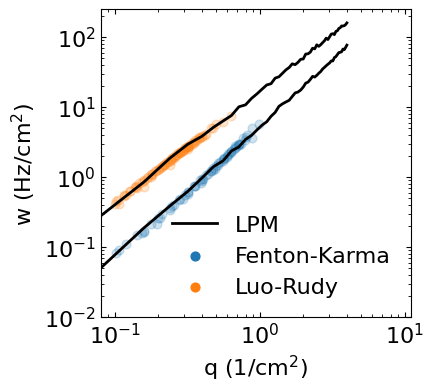

In [35]:
use_filterby_minN=True
minN=10
figsize = (4, 4) 
fontsize=16
x1lim=[0.08, 11]
x2lim=[0.01, 250]
fig, ax = plt.subplots(figsize=figsize)
#plot the lpm
df_rates_fk.plot(x='q',y='w',c='k',lw=2,ax=ax,label='_')
df_rates_lr.plot(x='q',y='w',c='k',lw=2,ax=ax,label='LPM')

#format_plot
format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)
# ax.plot(q_lst,w_lst,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.axis([5e-2,5e0,0.1,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

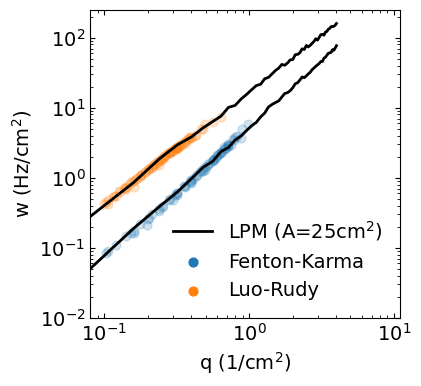

In [36]:
use_filterby_minN=True
minN=10
figsize = (4, 4) 
# fontsize=16
fontsize=14
x1lim=[0.08, 11]
x2lim=[0.01, 250]
fig, ax = plt.subplots(figsize=figsize)
#plot the lpm
df_rates_fk.plot(x='q',y='w',c='k',lw=2,ax=ax,label='_')
df_rates_lr.plot(x='q',y='w',c='k',lw=2,ax=ax,label=f'LPM (A={L**2}cm'+r'$^2$)')

#format_plot
format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)
# ax.plot(q_lst,w_lst,color='k')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.axis([5e-2,5e0,0.1,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [42]:
L=5
# L=10
rate_dir_fk = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_fk_L_{L}.csv'
rate_dir_lr = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_lr_L_{L}.csv'
df_rates_fk=pd.read_csv(rate_dir_fk)
df_rates_lr=pd.read_csv(rate_dir_lr)

In [43]:
print(f"annihilation rate density powerlaw fits:")
dict_fit_death_fk_lpm = print_fit_power_law(x=df_rates_fk['q'].values,y=df_rates_fk['w'].values)
dict_fit_death_lr_lpm = print_fit_power_law(x=df_rates_lr['q'].values,y=df_rates_lr['w'].values)

annihilation rate density powerlaw fits:
m = 1.870850 +/- 0.012366
M = 5.525075 +/- 0.159990 Hz/cm^2; B=2.493400 +/- 0.022941
RMSE=1.0835 Hz/cm^2; R^2=0.9995; MPE=3.7399%; N=50
m = 1.613812 +/- 0.012715
M = 16.943902 +/- 0.694124 Hz/cm^2; B=5.775093 +/- 0.063738
RMSE=2.2976 Hz/cm^2; R^2=0.9992; MPE=3.2161%; N=50


In [54]:
L=5
L=10
rate_dir_fk = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_fk_L_{L}.csv'
rate_dir_lr = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/control_data/lpm_table1_c_lr_L_{L}.csv'
df_rates_fk=pd.read_csv(rate_dir_fk)
df_rates_lr=pd.read_csv(rate_dir_lr)

In [65]:
x = df_rates_fk['q'].values
y = df_rates_fk['w'].values
yhat = dict_fit_death_fk_lpm['M'] * x ** dict_fit_death_fk_lpm['m']
print(f"FK: ")
pe=np.abs(y-yhat)/y
print(f"Mean % Disagreement: {np.mean(pe):.3%}")
print(f"Max % Disagreement: {np.max(pe):.3%}")

x = df_rates_lr['q'].values
y = df_rates_lr['w'].values
yhat = dict_fit_death_lr_lpm['M'] * x ** dict_fit_death_lr_lpm['m']
print(f"LR: ")
pe=np.abs(y-yhat)/y
print(f"Mean % Disagreement: {np.mean(pe):.3%}")
print(f"Max % Disagreement: {np.max(pe):.3%}")

FK: 
Mean % Disagreement: 14.087%
Max % Disagreement: 26.773%
LR: 
Mean % Disagreement: 33.125%
Max % Disagreement: 56.956%


In [67]:
x = df_rates_fk['q'].values
y = df_rates_fk['w'].values
yhat = dict_fit_death_fk_lpm['M'] * x ** dict_fit_death_fk_lpm['m']
print(f"FK: ")
rmse=np.sqrt(np.mean((y-yhat)**2))
print(f"RMSE: {np.max(rmse):.3f} Hz/cm^2")

x = df_rates_lr['q'].values
y = df_rates_lr['w'].values
yhat = dict_fit_death_lr_lpm['M'] * x ** dict_fit_death_lr_lpm['m']
print(f"LR: ")
rmse=np.sqrt(np.mean((y-yhat)**2))
print(f"RMSE: {np.max(rmse):.3f} Hz/cm^2")

FK: 
RMSE: 0.365 Hz/cm^2
LR: 
RMSE: 2.130 Hz/cm^2


In [69]:
# plt.plot(x,y)
# plt.plot(x,yhat)
# plt.xscale('log')
# plt.yscale('log')

# compute the dependence of the annihilation rates on attraction strength

In [111]:
alinear_lst=[
    1.5520, #1.781 - 2*0.115, #0.1145,
    9.3,
    ###the varkappa sweep####
    1,2,3,4,5,
    6,7,8,9, # <--- optional bc otherwise I had <60 jobs...
    10,15,20,25,30,
    40,50,60,70,80,90,100, # <--- optional bc otherwise I had <60 jobs...
]

In [113]:
#test it works normally in serial
# df_rates = compute_annihilation_rates_lpm(D,alinear,r,kappa,N0_lst,L,nb_dir)#,dt=1e-4,niter=500,neighbor=0,force_code=2,seed=0,**kwargs)

In [146]:
#launch subprocess in parallel for each alinear in alinear_lst
def routine(task):
    D,alinear,r,kappa,N0_lst,L,nb_dir = task
    df_rates = compute_annihilation_rates_lpm(D,alinear,r,kappa,N0_lst,L,nb_dir)#,dt=1e-4,niter=500,neighbor=0,force_code=2,seed=0,**kwargs)
    return df_rates

In [147]:
print("Number of cpu : ", os.cpu_count())
ncores=6

Number of cpu :  8


In [112]:
# niter=1000
# niter=500
# niter=200
# dt=1e-4
# dt=1e-5
L=5
# L=10 
D=0.42#0.4158
alinear=9.3#9.3154
# neighbor=0
# r=0.155;kappa=300  #table 1
# r=0.3;kappa=60 #not bad
# r=0.33;kappa=70 #noice at L=5. meh at L=10
r=0.314;kappa=75 #<<<< new table 1
# kappa=100; r=0.125 #wrong exponent
# seed=1
# seed=0

In [139]:
task_lst=[]
for alinear in alinear_lst:
    task_lst.append((D,alinear,r,kappa,N0_lst,L,nb_dir))

# p = multiprocess.Pool(ncores)
# df_rates_lst = p.map(routine, task_lst)
df_rates_lst = eval_routine_multiprocess(routine, task_lst, ncores)
print(f"{len(task_lst)} tasks completed!")
df_rates_lst_lr=list(df_rates_lst)

In [149]:
# niter=1000
niter=500
dt=1e-4
L=5
# L=10 
D=0.115
alinear=1.552
neighbor=0
# r=0.135;kappa=167  #table 1
# r=0.67;kappa=70 #
# r=0.67;kappa=10 #not bad
# r=0.67;kappa=7 #good
# r=0.67;kappa=8 #noice
# r=0.46;kappa=15 #noice
r=0.457;kappa=15 #noice <<<< new table 1
# r=0.67;kappa=5 #not bad
# kappa=100; r=0.125 #wrong exponent
#heretim

In [150]:
task_lst=[]
for alinear in alinear_lst:
    task_lst.append((D,alinear,r,kappa,N0_lst,L,nb_dir))

# p = multiprocess.Pool(ncores)
# df_rates_lst = p.map(routine, task_lst)
df_rates_lst = eval_routine_multiprocess(routine, task_lst, ncores)
print(f"{len(task_lst)} tasks completed!")
df_rates_lst_fk=list(df_rates_lst)

23 tasks completed!


In [151]:
data=dict(alinear_lst=alinear_lst,
         df_rates_lst_fk=df_rates_lst_fk,
         df_rates_lst_lr=df_rates_lst_lr)
pkl_dir=f"{nb_dir}/Data/lpm_results/figure_data_vs_alinear_at_A_{L**2}.pkl"
save_to_pickle(pkl_dir,data)
print(f"{pkl_dir=}")

pkl_dir='/Users/timothytyree/Documents/GitHub/bgmc/python/Data/lpm_results/figure_data_vs_alinear_at_A_25.pkl'


In [153]:
beep(3)

-n 
-n 
-n 


0

# TODO: plot the rates vs. alinear for one full cardiac model

In [228]:
pkl_dir='/Users/timothytyree/Documents/GitHub/bgmc/python/Data/lpm_results/figure_data_vs_alinear_at_A_25.pkl'
data = load_from_pickle(pkl_dir)
alinear_values = np.array(data['alinear_lst'])
df_rates_lst = data['df_rates_lst_fk']
# df_rates_lst = data['df_rates_lst_lr']
len(df_rates_lst)

23

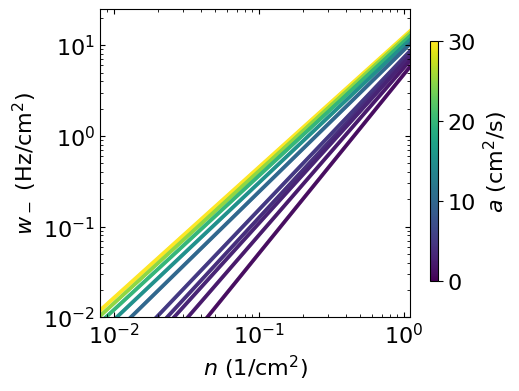

In [229]:
cmap = 'viridis'
c_col = 'rmse_full'
fontsize=16
xytext = (0.09, 10)
x2lim = [1e-2, 25]
x1lim = [8e-3, 1.1]  
# x2lim = [1e-2, 250]
# x1lim = [8e-3, 10.1]  
figsize = (4, 4)  
fig, ax = plt.subplots(figsize=figsize)
varkappa_lst = list(reversed([1, 2, 3, 4,
 5, 10, 15, 20, 25, 30]))
vmin = 0
vmax = 30
x_values = np.logspace(-3, .4, 1000)
for varkappa in varkappa_lst:
    #extract the data
    boo = alinear_values==varkappa
    df_rates = df_rates_lst[int(np.argwhere(boo))]
    assert boo.any()    
    x=df_rates['q'].values
    y=df_rates['w'].values
#     bo = (x<=1)&(x>0.1)
    bo = (x<=10)&(x>0.2)
    dict_fit = print_fit_power_law(x[bo],y[bo],printing=False)
    M = dict_fit['M']
    nu= dict_fit['m']
    y_values = M * x_values**nu
    
#     x_values=df_rates['q'].values
#     y_values=df_rates['w'].values
    
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)

# # #annotate the auxiliary trial that could have taken more than twenty hours on the open science grid   
# # #heretim
# M=3.1
# nu=4/3#2.8
# yhat_values=M*x_values**nu
# ax.scatter(x_values,
#            yhat_values,
#            c=[0]*x_values.shape[0], # pure diffusion
#            cmap=cmap,
#            alpha=0.6,
#            s=3,
#            vmin=vmin,
#            vmax=vmax)
  
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$n$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$w_-$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

# compute the power law fits versus alinear

In [242]:
xmax=10;xmin=0.2

In [243]:
df_rates_lst=list(df_rates_lst_fk)
# df_rates_lst=list(df_rates_lst_lr)
#TODO: compute df_death_rate_versus_alinear
dict_fit_lst=[]
for varkappa in alinear_values:
    #extract the data
    boo = alinear_values==varkappa
    df_rates = df_rates_lst[int(np.argwhere(boo))]
    assert boo.any()    
    x=df_rates['q'].values
    y=df_rates['w'].values
    bo = (x<=xmax)&(x>xmin)
    dict_fit = print_fit_power_law(x[bo],y[bo],printing=False)
    dict_fit['alinear']=varkappa
    #record
    dict_fit_lst.append(dict_fit)
df_death_rate_versus_alinear=pd.DataFrame(dict_fit_lst)
dict_data_fk=dict()
dict_data_fk['df_death_rate_versus_alinear']=df_death_rate_versus_alinear
# dict_data_lr['df_death_rate_versus_alinear']=df_death_rate_versus_alinear

In [244]:
#compute df_death_rate_versus_alinear
df_rates_lst=list(df_rates_lst_lr)
dict_fit_lst=[]
for varkappa in alinear_values:
    #extract the data
    boo = alinear_values==varkappa
    df_rates = df_rates_lst[int(np.argwhere(boo))]
    assert boo.any()    
    x=df_rates['q'].values
    y=df_rates['w'].values
    bo = (x<=xmax)&(x>xmin)
    dict_fit = print_fit_power_law(x[bo],y[bo],printing=False)
    dict_fit['alinear']=varkappa
    #record
    dict_fit_lst.append(dict_fit)
df_death_rate_versus_alinear=pd.DataFrame(dict_fit_lst)
dict_data_lr=dict()
dict_data_lr['df_death_rate_versus_alinear']=df_death_rate_versus_alinear

In [245]:
7/5,4/3,13/10

(1.4, 1.3333333333333333, 1.3)

In [246]:
# TODO: plot the power law fits versus alinear

In [247]:
#extrct xy vlues
alinear_fk = 1.552
alinear_lr = 9.3
dfdr = dict_data_fk['df_death_rate_versus_alinear']
alinear_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['alinear'].values
num_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['m'].values
Mm_vlues1 = dfdr[dfdr['alinear']!=alinear_fk]['M'].values
num_fk = dfdr[dfdr['alinear']==alinear_fk]['m'].values
Mm_fk = dfdr[dfdr['alinear']==alinear_fk]['M'].values

dfdr = dict_data_lr['df_death_rate_versus_alinear']
alinear_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['alinear'].values
num_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['m'].values
Mm_vlues2 = dfdr[dfdr['alinear']!=alinear_lr]['M'].values
num_lr = dfdr[dfdr['alinear']==alinear_lr]['m'].values
Mm_lr = dfdr[dfdr['alinear']==alinear_lr]['M'].values
num_lr

array([1.60874665])

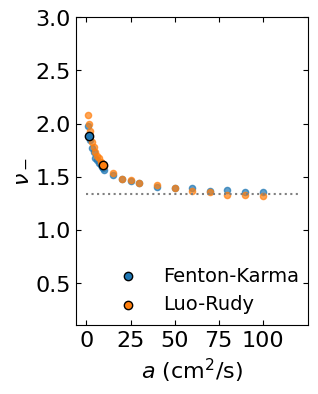

In [248]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='m',ax=ax,c='C0',alpha=0.7)#,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='m',ax=ax,c='C1',alpha=0.7)#,label='Luo-Rudy')

ax.scatter([alinear_fk],[num_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([alinear_lr],[num_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')

#plot dotted line at 4/3
xv=np.linspace(0,120,10)
ax.plot(xv,0.*xv+4/3,':',color='gray')#,'k--',lw=2)
#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')

# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
# leg = AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)
leg = AddLegend(ax=ax,xy=(0.065,0.25),fontsize=fontsize-2)
ax.set_ylim([0.1,3])
plt.show()

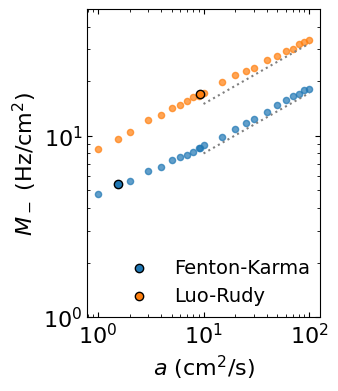

In [253]:
#plot the panel
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#plot xy values for full models
dict_data_fk['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M',ax=ax,c='C0',alpha=0.7)#,label='Fenton-Karma')
dict_data_lr['df_death_rate_versus_alinear'].plot.scatter(x='alinear',y='M',ax=ax,c='C1',alpha=0.7)#,label='Luo-Rudy')

ax.scatter([alinear_fk],[Mm_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([alinear_lr],[Mm_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')


#format plot
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$M_-$ (Hz/cm$^2)$',use_loglog=False,fontsize=fontsize)
ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_xscale('log')
ax.set_yscale('log')
# AddLegend(ax=ax,xy=(0.1,0.990),fontsize=fontsize-3)
# leg = AddLegend(ax=ax,xy=(0.1,0.25),fontsize=fontsize-3)
leg = AddLegend(ax=ax,xy=(0.065,0.25),fontsize=fontsize-2)
ax.set_ylim([1,50])

#####################
# plot the legend
#####################
#get 2 token points for either of the full models
#LR
num = 1/3 # 1.638 # ±0.017
# xlst=[0.14,0.8]
xlst=[1e1,1e2]
# y1 = 9
y1 = 8
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_lr = list(xlst)
ylst_lr = list(ylst)

#FK
num = 1/3 # 1.88 # ±0.03
# xlst=[1.4,8]
# xlst=[7.,1e3]
# y1 = 14
y1 = 15
y2 = y1 * (xlst[1]/xlst[0])**num
ylst=[y1,y2]
xlst_fk = list(xlst)
ylst_fk = list(ylst)


#mark the slope corresponding to the FK model
ax.plot(xlst_fk,ylst_fk,':',color='gray')
#mark the slope corresponding to the LR model
ax.plot(xlst_lr,ylst_lr,':',color='gray')
#TOOD(in .odg): annotate slope marker as $nu_-$
plt.show()

# recall birth rates

In [256]:
birth_rate_dir_fk = f'{nb_dir}/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)
#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [259]:
# DONE: compute powerlaw fits of birth rates wjr
print(f"creation rate density powerlaw fits:")
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

# wjr=recall_powerlaw_fits_to_full_models()
# print(f"\nannihilation rate density powerlaw fits:")
# print(f"wjr['fk_pbc']:")
# print_dict(wjr['fk_pbc'])
# print(f"\nwjr['lr_pbc']:")
# print_dict(wjr['lr_pbc'])

# print(f"\nwjr['fk_pbc']:")
# print_dict(wjr['fk_pbc'])
# print(f"\nwjr['lr_pbc']:")
# print_dict(wjr['lr_pbc'])

creation rate density powerlaw fits:
m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62


# TODO: estimate the mean termination time versus alinear

In [280]:
amax=9999
# num_iter=20 # max num particles to consider divided by two.
num_iter=50 # max num particles to consider divided by two.

In [281]:
# df_death_rate_versus_alinear = dict_data_fk['df_death_rate_versus_alinear']
df_death_rate_versus_alinear = dict_data_lr['df_death_rate_versus_alinear']

model_name='Luo-Rudy'
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']

In [282]:
#format data for extraction
# input size of computational domain with pbc
# L=5 #cm
A=L**2 #cm^2
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
alinear_lst = list(df_death_rate_versus_alinear.alinear.drop_duplicates().values)
printing=True
dict_results_master_lst=[]
for alinear in alinear_lst:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['m'])
    Delta_num = float(dg['Delta_m'])
    Mm = float(dg['M'])
    Delta_Mm = float(dg['Delta_M'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
    #estimate the quasistatic distribution
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #estimate the mean termination time
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
    
    #not used elsewhere
    # tscale=1e-3
    # tau*=tscale
    
    #estimate the mean number of particles
    nbar = np.sum(prob_qs*n_qs)
    nsqbar = np.sum(prob_qs*(n_qs**2))
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    #record
    dict_results_master_ = dict(
        model=model_name,
        alinear=alinear,
        tau=tau,
        nbar=nbar,
        qstarA=qstar*A,
        A=A,
        Mp=Mp,nup=nup,
        Mm=Mm,num=num,
        qstar=qstar,wstar=wstar,
        num_iter=num_iter,
        nsqbar=nsqbar)
    #print summary
    if printing:
        print(f"{model_name} ({A=:.0f} cm^2) with {alinear=:.4f} cm^2/s:")
        print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
        print(f"- mean num particles (correct qs distr): {nbar:.4f}")
        print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    #record
    dict_results_master_lst.append(dict_results_master_)

df_results_master = pd.DataFrame(dict_results_master_lst)
df_results_master

#extract xy
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=amax)&(df_results_master['alinear']>0)
xlr=df_results_master['alinear'].values[boo]
ylr=df_results_master['tau'].values[boo]

Luo-Rudy (A=25 cm^2) with alinear=1.5520 cm^2/s:
- mean termination time (correct qs distr): 15.2530 s
- mean num particles (correct qs distr): 9.4965
- mean num particles (qstar*A): 10.7500
Luo-Rudy (A=25 cm^2) with alinear=9.3000 cm^2/s:
- mean termination time (correct qs distr): 0.3843 s
- mean num particles (correct qs distr): 8.4817
- mean num particles (qstar*A): 3.9500
Luo-Rudy (A=25 cm^2) with alinear=1.0000 cm^2/s:
- mean termination time (correct qs distr): 53.0198 s
- mean num particles (correct qs distr): 11.0414
- mean num particles (qstar*A): 12.4500
Luo-Rudy (A=25 cm^2) with alinear=2.0000 cm^2/s:
- mean termination time (correct qs distr): 7.1757 s
- mean num particles (correct qs distr): 8.6350
- mean num particles (qstar*A): 9.6250
Luo-Rudy (A=25 cm^2) with alinear=3.0000 cm^2/s:
- mean termination time (correct qs distr): 2.3003 s
- mean num particles (correct qs distr): 7.6827
- mean num particles (qstar*A): 7.6750
Luo-Rudy (A=25 cm^2) with alinear=4.0000 cm^2/s:
-

In [283]:
df_death_rate_versus_alinear = dict_data_fk['df_death_rate_versus_alinear']
# df_death_rate_versus_alinear = dict_data_lr['df_death_rate_versus_alinear']

model_name='Fenton-Karma'
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']

In [284]:
#format data for extraction
# input size of computational domain with pbc
# L=5 #cm
A=L**2 #cm^2
# num_iter=20 # max num particles to consider divided by two.
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]
# alinear_lst = [30, 25, 20, 15, 10, 5, 4, 3, 2, 1]
alinear_lst = list(df_death_rate_versus_alinear.alinear.drop_duplicates().values)
printing=True
dict_results_master_lst=[]
for alinear in alinear_lst:
    dg = df_death_rate_versus_alinear [ df_death_rate_versus_alinear['alinear'] == alinear ]
    num = float(dg['m'])
    Delta_num = float(dg['Delta_m'])
    Mm = float(dg['M'])
    Delta_Mm = float(dg['Delta_M'])
    ################################
    # estimate mtt 
    ################################
    #implement model
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
    #estimate the quasistatic distribution
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
    #estimate the mean termination time
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, maxinf_num_inner_sum=num_iter, printing=False)#,**kwargs)
    
    #not used elsewhere
    # tscale=1e-3
    # tau*=tscale
    
    #estimate the mean number of particles
    nbar = np.sum(prob_qs*n_qs)
    nsqbar = np.sum(prob_qs*(n_qs**2))
    xv = np.arange(0.02, 1,0.001)
    qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
    #record
    dict_results_master_ = dict(
        model=model_name,
        alinear=alinear,
        tau=tau,
        nbar=nbar,
        qstarA=qstar*A,
        A=A,
        Mp=Mp,nup=nup,
        Mm=Mm,num=num,
        qstar=qstar,wstar=wstar,
        num_iter=num_iter,
        nsqbar=nsqbar)
    #print summary
    if printing:
        print(f"{model_name} ({A=:.0f} cm^2) with {alinear=:.4f} cm^2/s:")
        print(f"- mean termination time (correct qs distr): {tau:.4f} s")    
        print(f"- mean num particles (correct qs distr): {nbar:.4f}")
        print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    #record
    dict_results_master_lst.append(dict_results_master_)

df_results_master = pd.DataFrame(dict_results_master_lst)

#extract xy
df_results_master.sort_values(by='alinear',inplace=True)
boo = (df_results_master['alinear']<=amax)&(df_results_master['alinear']>0)
xfk=df_results_master['alinear'].values[boo]
yfk=df_results_master['tau'].values[boo]

Fenton-Karma (A=25 cm^2) with alinear=1.5520 cm^2/s:
- mean termination time (correct qs distr): 17.2154 s
- mean num particles (correct qs distr): 7.8961
- mean num particles (qstar*A): 8.2500
Fenton-Karma (A=25 cm^2) with alinear=9.3000 cm^2/s:
- mean termination time (correct qs distr): 0.9982 s
- mean num particles (correct qs distr): 7.8463
- mean num particles (qstar*A): 4.6000
Fenton-Karma (A=25 cm^2) with alinear=1.0000 cm^2/s:
- mean termination time (correct qs distr): 50.3876 s
- mean num particles (correct qs distr): 8.7712
- mean num particles (qstar*A): 9.3750
Fenton-Karma (A=25 cm^2) with alinear=2.0000 cm^2/s:
- mean termination time (correct qs distr): 11.6021 s
- mean num particles (correct qs distr): 7.6282
- mean num particles (qstar*A): 7.8250
Fenton-Karma (A=25 cm^2) with alinear=3.0000 cm^2/s:
- mean termination time (correct qs distr): 5.0375 s
- mean num particles (correct qs distr): 7.2042
- mean num particles (qstar*A): 6.8250
Fenton-Karma (A=25 cm^2) with al

In [285]:
aline_fk = 1.552
aline_lr = 9.3
tau_fk = yfk[xfk==aline_fk][0]
tau_lr = ylr[xlr==aline_lr][0]

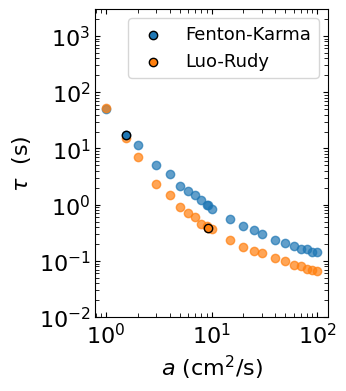

In [286]:
figsize=(3,4)
fontsize=15
alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
# ax.scatter(x=x,
#            y=y+tauinfty,#**0.5,#**2,#
#            c='k')
ax.scatter(xfk,yfk,c='C0',alpha=alpha)#,label='Fenton-Karma')
ax.scatter(xlr,ylr,c='C1',alpha=alpha)#,label='Luo-Rudy')
ax.scatter([aline_fk],[tau_fk],marker='o',edgecolor='k',c='C0',#'k',
           alpha=1,label='Fenton-Karma')
ax.scatter([aline_lr],[tau_lr],marker='o',edgecolor='k',c='C1',#c='k',
           alpha=1,label='Luo-Rudy')
format_plot(ax=ax,xlabel=r'$a$ (cm$^2/$s)',ylabel=r'$\tau$  (s)',fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.tick_params(top=True, right=True,direction='in',which='minor',length=3)
ax.set_ylim([1e-2,3000])
leg = ax.legend(loc='upper right',fontsize=fontsize-2)#,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()